In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/products/Bats_cmems.zarr"
path_to_cafe = "../../../1_data_processing/1_1_Forcing/products/Bats_cafe.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/products/Bats_obs_filtered.zarr"
export_file_name = "SeapoPym_Bats_VGPM_opti_E_2_groups"

In [3]:
LATITUDE = 31.6
LONGITUDE = -64.2
TIME_START = "2000-01-01"
TIME_END = "2020-01-01"

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 1MB
Dimensions:              (latitude: 1, longitude: 1, time: 7306, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 31.6
  * longitude            (longitude) float64 8B -64.2
  * time                 (time) datetime64[ns] 58kB 2000-01-01 ... 2020-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 175kB 20....
    U                    (latitude, longitude, time, depth) float64 175kB -0....
    V                    (latitude, longitude, time, depth) float64 175kB -0....
    mnkc_epi             (latitude, longitude, time) float64 58kB 0.477 ... 0...
    mnkc_hmlmeso         (latitude, longitude, time) float64 58kB 0.5029 ... ...
    mnkc_lmeso           (latitude, longitude, time) float64 58kB 0.7468 ... ...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 58kB 0.4302 ... ...
    mnkc_umeso           (latitude, longitude, time) float64 58kB 0.2267 ... ...
    npp                  (latitude, longitude, time) float64 58kB 328.2 ... 3...
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 175kB 115...
    zeu                  (latitude, longitude, time) float64 58kB 76.53 ... 73.8
    zooc                 (latitude, longitude, time) float64 58kB 0.3352 ... ...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[115.19071153611326 115.12054525865317 111.8252361565106 ... 110.78276574853243 109.49972524640543 110.86044984143466]]]
Units,meter


### Observations


In [6]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[107.83148939707903]]] [[[75.55788840025097]]] [[[78.96961285241998]]] [[[102.58833489163861]]] [[[56.44981985762868]]] [[[97.15950426887105]]] [[[50.79407887936223]]] [[[96.91200206110767]]] [[[92.65680609861826]]] [[[129.21393863283976]]] [[[91.90629182269338]]] [[[131.1712488359926]]] [[[70.35562278825793]]] [[[62.12092366091815]]] [[[72.83350356815573]]] [[[49.18141239888014]]] [[[106.11647637998723]]] [[[57.011359045288124]]] [[[73.72335615044013]]] [[[70.86197113579212]]] [[[119.04291181477608]]] [[[158.99969983093112]]] [[[116.01100997770381]]] [[[87.79708798233297]]] [[[139.17393044974028]]] [[[170.49910490071423]]] [[[131.5503009376781]]] [[[98.97252839147953]]] [[[138.61502413705625]]] [[[44.368130536231384]]] [[[132.47471009434696]]] [[[103.76398279338008]]] [[[115.36340203775478]]] [[[59.926014667851796]]] [[[69.34914673104475]]] [[[72.2610803763846]]] [[[121.63892353303106]]] [[[140.50821032303372]]] [[[77.84721883458846]]] [[[131.27296139790138]]] [[[124.89923480706915]]] [[[54.471291739129455]]] [[[154.9139873390006]]] [[[158.7533152162607]]] [[[58.43933432324844]]] [[[86.55304948518159]]] [[[54.76324391315145]]] [[[60.173535232526376]]] [[[66.6638148147453]]] [[[206.60094381339283]]] [[[86.92060787983226]]] [[[89.06240606598604]]] [[[135.8735375627362]]] [[[143.8691721528305]]] [[[158.545201249707]]] [[[90.96076177121066]]] [[[90.35862622042039]]] [[[52.87501873989764]]] [[[70.49821490985882]]] [[[151.0509296531297]]] [[[97.87781280472325]]] [[[170.76018354880682]]] [[[141.45045037126465]]] [[[142.77894374085452]]] [[[110.78021375136525]]] [[[145.23460112172424]]] [[[133.14689280233492]]] [[[160.60499431296716]]] [[[134.13496661401246]]] [[[96.75664031153823]]] [[[149.89256470879081]]] [[[262.03333052149685]]] [[[125.2345731625974]]] [[[95.7733259881037]]] [[[86.65000714474252]]] [[[42.76593038569825]]] [[[67.72706240571836]]] [[[97.50849028485162]]] [[[212.46807632164177]]] [[[54.64859406167802]]] [[[115.9226366561145]]] [[[105.0144745824183]]] [[[206.47267500606196]]] [[[78.59867006971004]]] [[[67.28116631971676]]] [[[47.63557217811036]]] [[[57.53609121931197]]] [[[52.61517940319014]]] [[[139.94417374748528]]] [[[159.1730353316254]]] [[[77.12071761930515]]] [[[126.92154989971013]]] [[[133.62664834148092]]] [[[58.86407807650767]]] [[[54.135961665732516]]] [[[86.51045485852714]]] [[[135.10100769764267]]] [[[87.69616597912149]]] [[[70.27462526562451]]] [[[110.93714148064659]]] [[[82.57002597928656]]] [[[104.9029597919927]]] [[[85.5380429471414]]] [[[84.41529756988878]]] [[[303.45343163711914]]] [[[147.7214925198176]]] [[[174.8561724939779]]] [[[95.24885384817858]]] [[[75.69442031508542]]]]
Units,milligram/meter2
Magnitude,[[[[272.02414603841964]]] [[[150.8273879134781]]] [[[239.1491112622932]]] [[[123.8135076278397]]] [[[112.5928472160311]]] [[[115.39252177948184]]] [[[138.24823208035113]]] [[[133.04868079575803]]] [[[160.1535395229381]]] [[[224.10542481633144]]] [[[116.66219534395758]]] [[[295.6206157699114]]] [[[116.71033077918372]]] [[[102.65745859219528]]] [[[94.89707305297162]]] [[[123.7043922551985]]] [[[109.23754921469275]]] [[[105.3304032585592]]] [[[269.5666934072216]]] [[[164.00251653018557]]] [[[266.3854305725997]]] [[[237.5892461214104]]] [[[168.84770759131146]]] [[[144.47622073042132]]] [[[194.2503717236101]]] [[[226.9934447843836]]] [[[236.3857715310892]]] [[[143.1420865166026]]] [[[260.29518107184776]]] [[[95.1423547862502]]] [[[204.2648973011637]]] [[[226.9837123605189]]] [[[244.84041177161788]]] [[[91.79575883211842]]] [[[160.41368284251763]]] [[[150.96582397104555]]] [[[219.63777358791123]]] [[[222.1442654827852]]] [[[117.38866332199846]]] [[[176.64380059072445]]] [[[169.4437171508491]]] [[[115.04168564209964]]] [[[202.53184384991485]]] [[[209.03617715889376]]] [[[164.1970848709182]]] [[[150.14304502531502]]] [[[102.80117717030187]]] [[[148.54554722673873]]] [[[154.93590063840804]]] [[[359.7175654024709]]] [[[170.6434676436841]]] [[[156.01067729245855]]] [[[158.88277896022146]]] [[

Create structure for SeapoPym simulation.


In [7]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["npp"], resolution=1 / 12, timestep=1),
)

2025-01-21 12:07:00,355 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [8]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.1),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=-0.15,
        inv_lambda_max=150,
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=1,
        night_layer=0,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.1),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=-0.15,
        inv_lambda_max=150,
    ),
]
# [1, 1, 0.1668, 10.38, -0.11, 150, -0.15]

In [9]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations)],
)

Set the genetic algorithm meta parameters.


In [10]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.1,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [11]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [12]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [13]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51713,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:51726,Total threads: 3
Dashboard: http://127.0.0.1:51731/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:51716,


## Run the optimization


In [14]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,0.033706,0.013981,0.020428,0.092328,500,0.000
1,0.025834,0.005699,0.020419,0.057669,500,0.172
2,0.023087,0.003593,0.020414,0.041242,500,0.158
3,0.021346,0.001193,0.020411,0.030577,500,0.144
4,0.020718,0.000462,0.020411,0.024654,500,0.214
5,0.020572,0.000678,0.020411,0.031563,500,0.190
6,0.020538,0.000801,0.020411,0.034783,500,0.146
7,0.020458,0.000381,0.020411,0.028778,500,0.204
8,0.020518,0.001113,0.020411,0.043432,500,0.212


Generations: 100%|██████████| 10/10 [03:33<00:00, 21.32s/it]


## Plot the results


In [15]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,0.033706,0.013981,0.020428,0.092328,500,0.000
1,0.025834,0.005699,0.020419,0.057669,500,0.172
2,0.023087,0.003593,0.020414,0.041242,500,0.158
3,0.021346,0.001193,0.020411,0.030577,500,0.144
4,0.020718,0.000462,0.020411,0.024654,500,0.214
5,0.020572,0.000678,0.020411,0.031563,500,0.190
6,0.020538,0.000801,0.020411,0.034783,500,0.146
7,0.020458,0.000381,0.020411,0.028778,500,0.204
8,0.020518,0.001113,0.020411,0.043432,500,0.212


In [16]:
viewer.hall_of_fame

D1N1_energy_coefficient  D2N1_energy_coefficient  \
generation individual                                                     
7          448                        0.042458                 0.035568   
           493                        0.042458                 0.035568   
9          232                        0.042458                 0.035568   
           231                        0.042458                 0.035568   
           410                        0.042458                 0.035568   
...                                        ...                      ...   
0          187                        0.093078                 0.090898   
           475                        0.098974                 0.086163   
           89                         0.098007                 0.088441   
           322                        0.095451                 0.092389   
           321                        0.095025                 0.095984   

                        fitness  
generation individual            
7          448         0.020411  
           493         0.020411  
9          232         0.020411  
           231         0.020411  
           410         0.020411  
...                         ...  
0          187         0.084033  
           475         0.087147  
           89          0.088227  
           322         0.088922  
           321         0.092328  

[4188 rows x 3 columns]

In [17]:
viewer.fitness_evolution()

In [18]:
viewer.box_plot(3, nbest=1000)

In [19]:
viewer.parallel_coordinates(500, unselected_opacity=0)

# Generate plots at each station


In [44]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual D1N1: {list(best_individual[0])}")
print(f"Best individual D2N1: {list(best_individual[1])}")
pd.DataFrame(best_individual, columns=cost_function.functional_groups[0].parameters_name)

Best individual D1N1: [0.0, 0.0, 0.04245843966376247, 10.38, -0.11, 150.0, -0.15]
Best individual D2N1: [1.0, 0.0, 0.03556840848238447, 10.38, -0.11, 150.0, -0.15]


AttributeError: 'AllGroups' object has no attribute 'parameters_name'

In [59]:
from dataclasses import asdict
D1N1 = asdict(cost_function.functional_groups.functional_groups[0])
D2N1 = asdict(cost_function.functional_groups.functional_groups[1])
D1N1["energy_coefficient"] = viewer.hall_of_fame.iloc[0].D1N1_energy_coefficient
D2N1["energy_coefficient"] = viewer.hall_of_fame.iloc[0].D2N1_energy_coefficient
result = pd.DataFrame([D1N1, D2N1])
result

,name,day_layer,night_layer,energy_coefficient,tr_max,tr_rate,inv_lambda_max,inv_lambda_rate
0,D1N1,0,0,0.042458,10.38,-0.11,150,-0.15
1,D2N1,1,0,0.035568,10.38,-0.11,150,-0.15


In [57]:
viewer.hall_of_fame.iloc[0].D1N1_energy_coefficient

0.04245843966376247

## Run simulation


In [21]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1", "D2N1"]),
)

model_print.run()

## Plot


### Taylor Diagram


Convert to pandas series.


In [33]:
biomass_pandas = (
    model_print.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_post = observations.pint.quantify().pint.to("mg/m2").pint.dequantify()
observations_day_pandas = (
    observations_post.day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations_post.night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [34]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_d2n1 = biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [37]:
fig = go.Figure(
    layout={
        "title": export_file_name,
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions D1N1",
    )
)
fig.add_trace(
    go.Scatter(
        x=(monthly_pred_d1n1 + monthly_pred_d2n1).index,
        y=(monthly_pred_d1n1 + monthly_pred_d2n1),
        fill=None,
        mode="lines",
        line={"color": "black", "dash": "dash"},
        name="Predictions D2N1",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [26]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [-0.045747048156149356, -0.11406929429187652]
norm STD [890.6858256612973, 900.4195333306246]
bias [1615.8529226921946, 1771.6004499356106]
NRMSE [890.7321328708557, 900.5341506266194]
name ['HOT Day', 'HOT Night']


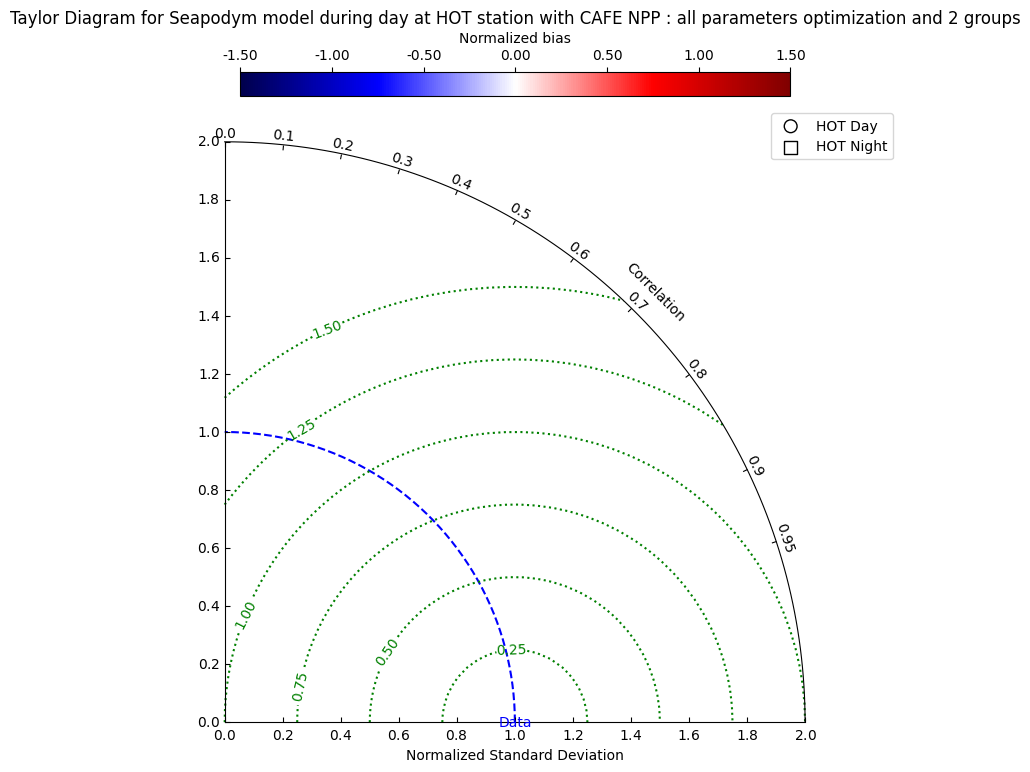

In [27]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_d1n1 + monthly_pred_d2n1]
all_obs = [monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [28]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,-0.045747,890.685826,1615.852923,890.732133
1,HOT Night,-0.114069,900.419533,1771.600450,900.534151
